In [1]:
folder_name = '/home/yoyo/Desktop/SimCLR/runs/amazon_Jul02_13-42-58'

In [2]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import classification_report
import importlib.util
import glob
from PIL import Image
from sklearn.metrics import confusion_matrix

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [4]:
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/home/yoyo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 96,
 'epochs': 100,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'model': {'out_dim': 128, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(256,256,3)',
  'num_workers': 0,
  'valid_size': 0.1},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [5]:
checkpoints_folder

'/home/yoyo/Desktop/SimCLR/runs/amazon_Jul02_13-42-58/checkpoints'

In [6]:
def _load_facemask(prefix="train", img_size=96):
    img_list = glob.glob('../data/satellite/amazon/' + prefix + '/**/*')
    np.random.shuffle(img_list)
    X_train = []
    for f in img_list:
        img = Image.open(f).convert('RGB')#.resize((img_size, img_size))
        X_train.append(img)
    X_train = np.stack(X_train).transpose(0,3,1,2)
    y_train = np.array([f.split('/')[-2] == 'agri' for f in img_list])
    
    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train

In [7]:
# load facemask train data
# X_train, y_train = _load_facemask("train")
Xtrain1, ytrain1 = _load_facemask("train")
Xtrain2, ytrain2 = _load_facemask("unlabeled")
n = Xtrain2.shape[0]
n_spl = int(n*1.0)
X_train = np.concatenate((Xtrain1, Xtrain2[:n_spl]))
y_train = np.concatenate((ytrain1, ytrain2[:n_spl]))

train images
(2111, 3, 256, 256)
(2111,)
unlabeled images
(16895, 3, 256, 256)
(16895,)


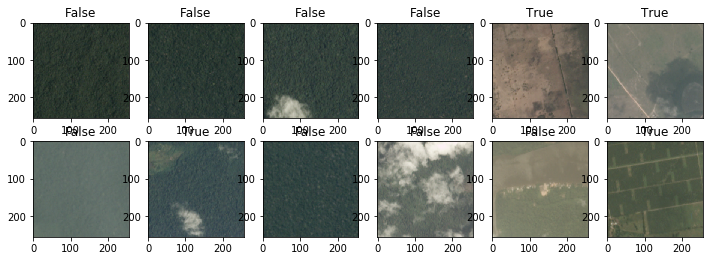

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i].transpose(1,2,0))
    ax.title.set_text(y_train[i])
plt.show()

In [9]:
# load facemask test data
X_test, y_test = _load_facemask("test")

test images
(2112, 3, 256, 256)
(2112,)


## Test protocol #1 PCA features

In [10]:
# scaler = preprocessing.StandardScaler()
# scaler.fit(X_train.reshape((X_train.shape[0],-1)))

# pca = PCA(n_components=min(config['model']['out_dim'], X_train.shape[0]))

# X_train_pca = pca.fit_transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
# X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))

# print("PCA features")
# print(X_train_pca.shape)
# print(X_test_pca.shape)

In [11]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=10.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    predIdxs = clf.predict(X_test)
    # show a nicely formatted classification report
    print(classification_report(y_test, predIdxs, target_names=['no_agri', 'agri'], digits=3))
    print(confusion_matrix(y_test, predIdxs))
    
    print("-------------------------------")
    svm = SVC(random_state=0)
    svm.fit(X_train, y_train)
    print("SVM feature eval")
    print("Train score:", svm.score(X_train, y_train))
    print("Test score:", svm.score(X_test, y_test))
    predIdxs = svm.predict(X_test)
    # show a nicely formatted classification report
    print(classification_report(y_test, predIdxs, target_names=['no_agri', 'agri'], digits=3))
    print(confusion_matrix(y_test, predIdxs))
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))
    predIdxs = neigh.predict(X_test)
    # show a nicely formatted classification report
    print(classification_report(y_test, predIdxs, target_names=['no_agri', 'agri'], digits=3))
    print(confusion_matrix(y_test, predIdxs))

In [12]:
# linear_model_eval(X_train_pca, y_train, X_test_pca, y_test)

# ## clean up resources
# del X_train_pca
# del X_test_pca

## Protocol #2 Logisitc Regression

In [13]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, '../../../models/resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [14]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [15]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [16]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(19006, 512)


In [17]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy().reshape((-1,512)))
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(2112, 512)


In [18]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_feature)

linear_model_eval(scaler.transform(X_train_feature), y_train, scaler.transform(X_test_feature), y_test)

del X_train_feature
del X_test_feature

Logistic Regression feature eval
Train score: 0.8783542039355993
Test score: 0.8821022727272727
              precision    recall  f1-score   support

     no_agri      0.884     0.897     0.890      1127
        agri      0.880     0.865     0.873       985

    accuracy                          0.882      2112
   macro avg      0.882     0.881     0.881      2112
weighted avg      0.882     0.882     0.882      2112

[[1011  116]
 [ 133  852]]
-------------------------------
SVM feature eval
Train score: 0.8906661054403873
Test score: 0.8858901515151515
              precision    recall  f1-score   support

     no_agri      0.898     0.886     0.892      1127
        agri      0.872     0.885     0.879       985

    accuracy                          0.886      2112
   macro avg      0.885     0.886     0.885      2112
weighted avg      0.886     0.886     0.886      2112

[[999 128]
 [113 872]]
-------------------------------
KNN feature eval
Train score: 0.8833526254866884
Test sc